In [21]:
#import sys
#!{sys.executable} -m pip install --upgrade "scikit-learn>=1.6.1,<1.7" category_encoders shap lyft_fugue

In [1]:
#usual packages
import sklearn
import lightgbm as lgb
import numpy as np
from IPython.display import IFrame
from sklearn.model_selection import GroupKFold
from datetime import date
import pandas as pd
from pandas import DataFrame
import subprocess
import sys

#lyft packages
import lyft_data_toolkit.db.write.df
from lyft_data_toolkit.db.read import Compute
from lyft_data_toolkit.db.read import Query
from lyft_data_toolkit.db.read.df import to_dataframe  
from lyft_data_toolkit.v1_to_v3 import hive
from lyft_data_toolkit.v1_to_v3 import presto
from lyft_data_toolkit.v1_to_v3 import spark
from lyft_data_toolkit.v1_to_v3 import trino

#other packages
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

In [2]:
SQL ="""
--higherlimit
WITH pre_final_table AS (
SELECT DISTINCT 
       sub1.rider_lyft_id,
       sub1.business_program_user_id,
       sub1.business_program_type,
       sub1.business_program_type_cleaned,
       sub1.lyft_signed_up_at,
       sub1.bp_created_at,
       sub1.bp_activated_at,
       sub1.user_type,
       sub1.sub_user_type,
       sub2.first_ride_finished_at
  FROM tfrancois.causal_analysis_bp_raw_data_step_4 sub1
  LEFT JOIN coco.dim_user sub2 
    ON sub1.rider_lyft_id = sub2.user_lyft_id
 WHERE sub1.is_business_ride = TRUE 
) 

,pre_final_table_v2 AS (
SELECT rider_lyft_id,
       business_program_user_id,
       business_program_type,
       business_program_type_cleaned,
       lyft_signed_up_at,
       bp_created_at,
       bp_activated_at,
       user_type,
       sub_user_type,
       first_ride_finished_at,
       ROW_NUMBER() OVER(PARTITION BY rider_lyft_id ORDER BY bp_activated_at DESC) rnk 
  FROM pre_final_table 
 WHERE TRUE
)

SELECT DATE_TRUNC('week',CAST(bp_activated_at AS DATE)) week,
       business_program_type_cleaned,
       CASE WHEN DATE_DIFF('day',first_ride_finished_at,bp_activated_at) > 0 THEN 'PP' ELSE 'NP' END AS activation_type, -- proxy for NP/PP
       COUNT(DISTINCT rider_lyft_id) count_activations
  FROM pre_final_table_v2
 WHERE TRUE 
   AND rnk = 1
 GROUP BY 1,2,3
"""  
df = pd.DataFrame()
df = presto.query(SQL, scheduled=True)

{"ts": "2025-11-05T20:59:01.392Z", "uuid": "e53ad689-8665-4e32-9466-023761b06fe5", "name": "lyft_data_toolkit.v1_to_v3.presto", "lvlname": "WARNING", "lvlno": 30, "pid": 4631, "call_site": "code/venvs/venv/lib/python3.10/site-packages/lyft_data_toolkit/v1_to_v3/presto.py:18", "revision": "b8758af9c9", "msg": "DEPRECATION WARNING: presto.query method is outdated.Please use the new query function in the lyft_data_toolkit package."}
/code/venvs/venv/lib/python3.10/site-packages/lyft_stats/client.py:347: UserWarning: Attempting to establish a new TCP stats connection
  warnings.warn("Attempting to establish a new TCP stats connection")


Created Mozart command
{'mozart_id': 563516105, 'backend': 'presto', 'native_command_id': '', 'job_url': 'https://sql.lyft.net/databases/mozart/queries/563516105', 'query': "--higherlimit\nWITH pre_final_table AS (\nSELECT DISTINCT \n       sub1.rider_lyft_id,\n       sub1.business_program_user_id,\n       sub1.business_program_type,\n       sub1.business_program_type_cleaned,\n       sub1.lyft_signed_up_at,\n       sub1.bp_created_at,\n       sub1.bp_activated_at,\n       sub1.user_type,\n       sub1.sub_user_type,\n       sub2.first_ride_finished_at\n  FROM tfrancois.causal_analysis_bp_raw_data_step_4 sub1\n  LEFT JOIN coco.dim_user sub2 \n    ON sub1.rider_lyft_id = sub2.user_lyft_id\n WHERE sub1.is_business_ride = TRUE \n) \n\n,pre_final_table_v2 AS (\nSELECT rider_lyft_id,\n       business_program_user_id,\n       business_program_type,\n       business_program_type_cleaned,\n       lyft_signed_up_at,\n       bp_created_at,\n       bp_activated_at,\n       user_type,\n       sub_u

In [3]:
df.columns

Index(['week', 'business_program_type_cleaned', 'activation_type',
       'count_activations'],
      dtype='object')

In [4]:
df_pivot = df.pivot_table(
    index=["week", "activation_type"],
    columns="business_program_type_cleaned",
    values="count_activations",
    fill_value=0
).reset_index()

print(df_pivot)

business_program_type_cleaned       week activation_type  managed  organic
0                             2021-08-09              NP        9        1
1                             2021-08-09              PP      930      836
2                             2021-08-16              NP       39        4
3                             2021-08-16              PP     1953     1706
4                             2021-08-23              NP       16        3
..                                   ...             ...      ...      ...
437                           2025-10-13              PP     1509     4748
438                           2025-10-20              NP      180      113
439                           2025-10-20              PP     1498     4612
440                           2025-10-27              NP       84       46
441                           2025-10-27              PP      661     1657

[442 rows x 4 columns]


In [5]:
np_df = df_pivot[df_pivot.activation_type == "NP"]
pp_df = df_pivot[df_pivot.activation_type == "PP"]

Training Metrics: {'MAE': 18.223101853993764, 'MSE': 542.5304542178917, 'RMSE': 23.292283147383635, 'R2': 0.6488727791630525}
Test/Future Metrics: {'MAE': 34.687379215284544, 'MSE': 1692.5697247841424, 'RMSE': 41.140852261276045, 'R2': -0.48940095432689734}


/tmp/ipykernel_4631/2602512006.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  np_df["week"] = pd.to_datetime(np_df["week"])


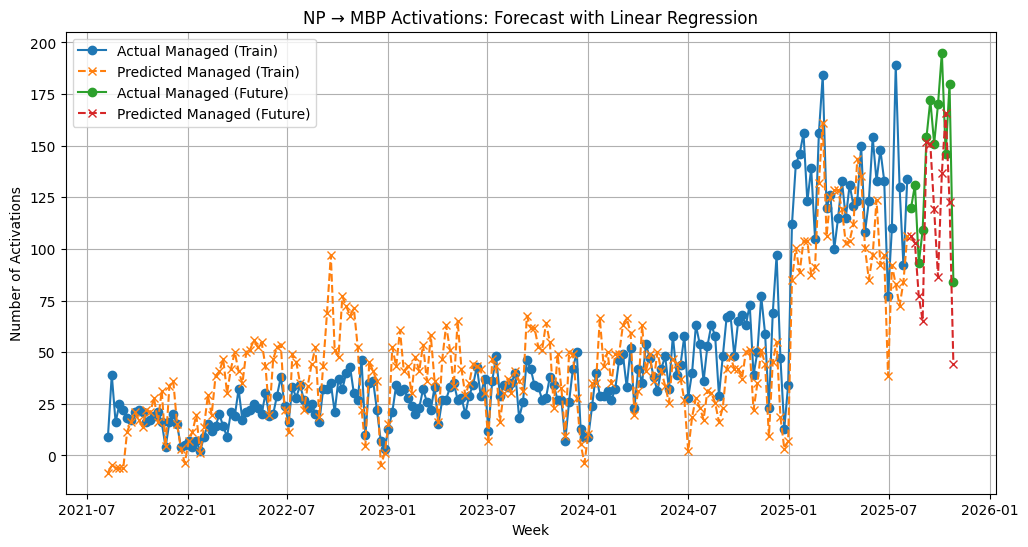

In [6]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

np_df["week"] = pd.to_datetime(np_df["week"])

train_df = np_df[np_df["week"] <= "2025-08-04"].sort_values("week")
test_df = np_df[np_df["week"] > "2025-08-04"].sort_values("week")

X_train = train_df[["organic"]]
y_train = train_df["managed"]

lr = LinearRegression()
lr.fit(X_train, y_train)

train_df["predicted_managed"] = lr.predict(X_train)
train_df["error"] = train_df["managed"] - train_df["predicted_managed"]

X_test = test_df[["organic"]]
y_test = test_df["managed"]
test_df["predicted_managed"] = lr.predict(X_test)
test_df["error"] = y_test - test_df["predicted_managed"]

def compute_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

train_metrics = compute_metrics(train_df["managed"], train_df["predicted_managed"])
test_metrics = compute_metrics(test_df["managed"], test_df["predicted_managed"])

print("Training Metrics:", train_metrics)
print("Test/Future Metrics:", test_metrics)

plt.figure(figsize=(12,6))
plt.plot(train_df["week"], train_df["managed"], marker='o', label="Actual Managed (Train)")
plt.plot(train_df["week"], train_df["predicted_managed"], marker='x', linestyle="--", label="Predicted Managed (Train)")
plt.plot(test_df["week"], test_df["managed"], marker='o', label="Actual Managed (Future)")
plt.plot(test_df["week"], test_df["predicted_managed"], marker='x', linestyle="--", label="Predicted Managed (Future)")
plt.xlabel("Week")
plt.ylabel("Number of Activations")
plt.title("NP → MBP Activations: Forecast with Linear Regression")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_4631/2545709438.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pp_df["week"] = pd.to_datetime(pp_df["week"])


Training Metrics: {'MAE': 108.97546733582027, 'MSE': 40626.878479182655, 'RMSE': 201.5611035869338, 'R2': 0.5656440731118697}
Test/Future Metrics: {'MAE': 285.27786839870595, 'MSE': 86216.92388766108, 'RMSE': 293.62718519861386, 'R2': 0.019625588632075308}


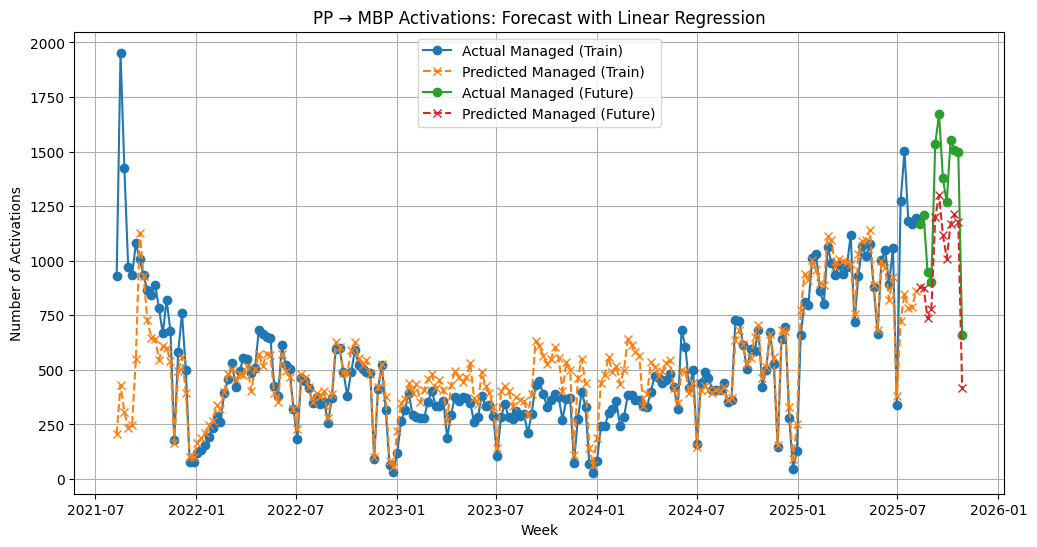

In [7]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

pp_df["week"] = pd.to_datetime(pp_df["week"])

train_df = pp_df[pp_df["week"] <= "2025-08-04"].sort_values("week")
test_df = pp_df[pp_df["week"] > "2025-08-04"].sort_values("week")

X_train = train_df[["organic"]]
y_train = train_df["managed"]

lr = LinearRegression()
lr.fit(X_train, y_train)

train_df["predicted_managed"] = lr.predict(X_train)
train_df["error"] = train_df["managed"] - train_df["predicted_managed"]

X_test = test_df[["organic"]]
y_test = test_df["managed"]
test_df["predicted_managed"] = lr.predict(X_test)
test_df["error"] = y_test - test_df["predicted_managed"]

def compute_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

train_metrics = compute_metrics(train_df["managed"], train_df["predicted_managed"])
test_metrics = compute_metrics(test_df["managed"], test_df["predicted_managed"])

print("Training Metrics:", train_metrics)
print("Test/Future Metrics:", test_metrics)

plt.figure(figsize=(12,6))
plt.plot(train_df["week"], train_df["managed"], marker='o', label="Actual Managed (Train)")
plt.plot(train_df["week"], train_df["predicted_managed"], marker='x', linestyle="--", label="Predicted Managed (Train)")
plt.plot(test_df["week"], test_df["managed"], marker='o', label="Actual Managed (Future)")
plt.plot(test_df["week"], test_df["predicted_managed"], marker='x', linestyle="--", label="Predicted Managed (Future)")
plt.xlabel("Week")
plt.ylabel("Number of Activations")
plt.title("PP → MBP Activations: Forecast with Linear Regression")
plt.legend()
plt.grid(True)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                managed   No. Observations:                  208
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -833.697
Date:                Wed, 05 Nov 2025   AIC                           1679.395
Time:                        20:59:23   BIC                           1699.391
Sample:                             0   HQIC                          1687.481
                                - 208                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
organic        0.6010      0.050     12.025      0.000       0.503       0.699
ar.L1         -0.5993      0.062     -9.614      0.000      -0.721      -0.477
ar.L2         -0.6054      0.053    -11.317      0.0

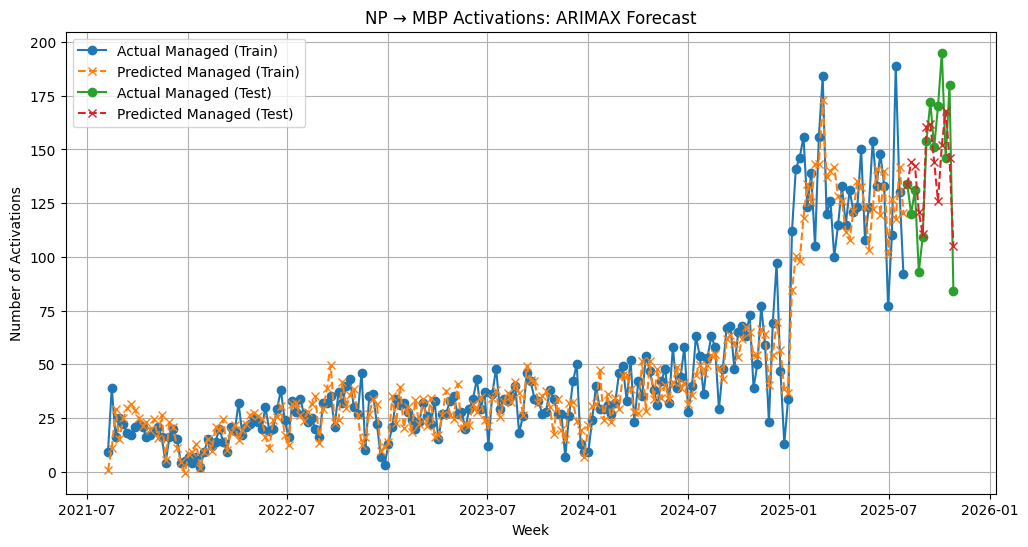

In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

np_df = df_pivot[df_pivot["activation_type"] == "NP"].copy()

np_df = np_df.sort_values("week").reset_index(drop=True)

#np_df["organic_lag1"] = np_df["organic"].shift(1).fillna(method='bfill')
#np_df["organic_lag2"] = np_df["organic"].shift(2).fillna(method='bfill')

launch_date = "2025-08-04"
train_df = np_df[np_df["week"] < launch_date].copy()
test_df = np_df[np_df["week"] >= launch_date].copy()

y_train = train_df["managed"]
X_train = train_df[["organic"]]

y_test = test_df["managed"]
X_test = test_df[["organic"]]

model = ARIMA(endog=y_train, exog=X_train, order=(4,1,0))
result = model.fit()
print(result.summary())

train_df["predicted_managed"] = result.predict(start=0, end=len(y_train)-1, exog=X_train)
test_df["predicted_managed"] = result.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

train_df["error"] = train_df["managed"] - train_df["predicted_managed"]
test_df["error"] = test_df["managed"] - test_df["predicted_managed"]

def calc_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": 1 - np.sum((y_true - y_pred)**2)/np.sum((y_true - np.mean(y_true))**2)
    }

print("Training Metrics:", calc_metrics(train_df["managed"], train_df["predicted_managed"]))
print("Test/Future Metrics:", calc_metrics(test_df["managed"], test_df["predicted_managed"]))

plt.figure(figsize=(12,6))
plt.plot(train_df["week"], train_df["managed"], marker='o', label="Actual Managed (Train)")
plt.plot(train_df["week"], train_df["predicted_managed"], marker='x', linestyle='--', label="Predicted Managed (Train)")
plt.plot(test_df["week"], test_df["managed"], marker='o', label="Actual Managed (Test)")
plt.plot(test_df["week"], test_df["predicted_managed"], marker='x', linestyle='--', label="Predicted Managed (Test)")
plt.xlabel("Week")
plt.ylabel("Number of Activations")
plt.title("NP → MBP Activations: ARIMAX Forecast")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
import pickle

with open("arimax_model_np.pkl", "wb") as f:
    pickle.dump(result, f)

with open("arimax_model_np.pkl", "rb") as f:
    loaded_model = pickle.load(f)

predictions = loaded_model.predict(start=0, end=len(y_train)-1, exog=X_train)

                               SARIMAX Results                                
Dep. Variable:                managed   No. Observations:                  208
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1270.479
Date:                Wed, 05 Nov 2025   AIC                           2550.959
Time:                        20:59:24   BIC                           2567.646
Sample:                             0   HQIC                          2557.706
                                - 208                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2054     79.377     -0.053      0.958    -159.781     151.370
organic        0.2590      0.008     31.745      0.000       0.243       0.275
ar.L1          0.8466      0.047     18.133      0.0

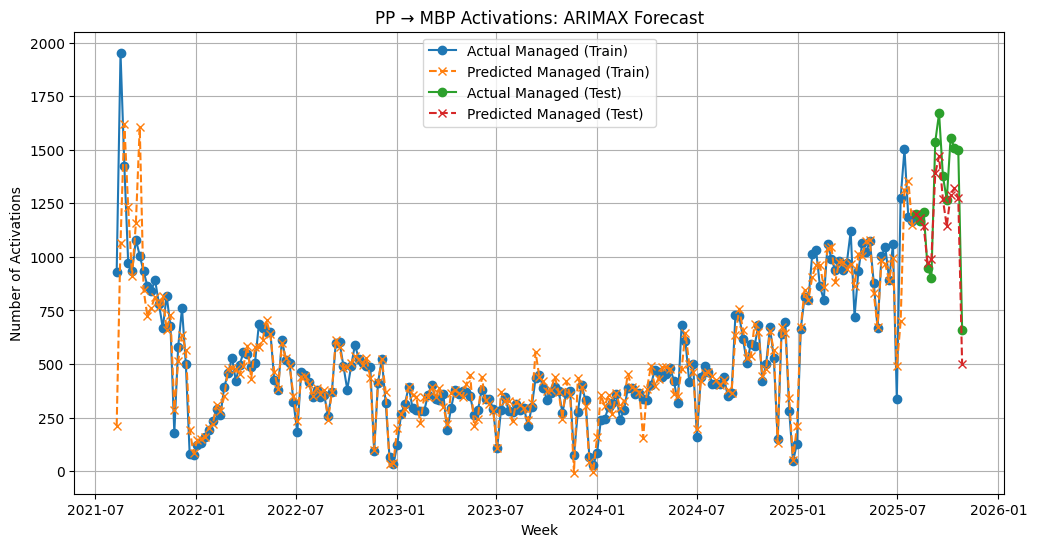

In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

np_df = df_pivot[df_pivot["activation_type"] == "PP"].copy()

np_df = np_df.sort_values("week").reset_index(drop=True)

#np_df["organic_lag1"] = np_df["organic"].shift(1).fillna(method='bfill')
#np_df["organic_lag2"] = np_df["organic"].shift(2).fillna(method='bfill')

launch_date = "2025-08-04"
train_df = np_df[np_df["week"] < launch_date].copy()
test_df = np_df[np_df["week"] >= launch_date].copy()

y_train = train_df["managed"]
X_train = train_df[["organic"]]

y_test = test_df["managed"]
X_test = test_df[["organic"]]

model = ARIMA(endog=y_train, exog=X_train, order=(2,0,0))
result = model.fit()
print(result.summary())

train_df["predicted_managed"] = result.predict(start=0, end=len(y_train)-1, exog=X_train)
test_df["predicted_managed"] = result.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

train_df["error"] = train_df["managed"] - train_df["predicted_managed"]
test_df["error"] = test_df["managed"] - test_df["predicted_managed"]

def calc_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": 1 - np.sum((y_true - y_pred)**2)/np.sum((y_true - np.mean(y_true))**2)
    }

print("Training Metrics:", calc_metrics(train_df["managed"], train_df["predicted_managed"]))
print("Test/Future Metrics:", calc_metrics(test_df["managed"], test_df["predicted_managed"]))

plt.figure(figsize=(12,6))
plt.plot(train_df["week"], train_df["managed"], marker='o', label="Actual Managed (Train)")
plt.plot(train_df["week"], train_df["predicted_managed"], marker='x', linestyle='--', label="Predicted Managed (Train)")
plt.plot(test_df["week"], test_df["managed"], marker='o', label="Actual Managed (Test)")
plt.plot(test_df["week"], test_df["predicted_managed"], marker='x', linestyle='--', label="Predicted Managed (Test)")
plt.xlabel("Week")
plt.ylabel("Number of Activations")
plt.title("PP → MBP Activations: ARIMAX Forecast")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
import pickle

with open("arimax_model_pp.pkl", "wb") as f:
    pickle.dump(result, f)

with open("arimax_model_pp.pkl", "rb") as f:
    loaded_model = pickle.load(f)

predictions = loaded_model.predict(start=0, end=len(y_train)-1, exog=X_train)